In [1]:
# import libraries
import tensorflow as tf # for modell training
import math
import matplotlib.pyplot as plt # to show graphical results
from matplotlib.ticker import MaxNLocator

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# own modules
import modules.config as config
from modules.ai_dataset import ai_dataset
from modules.export_trained_model import export_trained_model

In [3]:
# import training and testing data into one class object
raw_data = ai_dataset(config.TRAINING_DATA)
raw_data.load_data(config.TEST_DATA)
raw_data.resize(config.IMG_SIZE)
raw_data.shuffle()
raw_data.tf_ready()

100%|██████████| 100/100 [00:00<00:00, 356.97it/s]
Errors: 0; Exceptions: 0
24946 Images ready


In [4]:
raw_data.get_status()

Image Data: (24946, 60, 60, 3)
Label Data: (24946,)
Class labels: dict_items([('Cat', 0), ('Dog', 1)])


In [8]:
# list of optimizers
optimizers = ["adadelta", "adagrad", "adam", "adamax", "ftrl", "nadam", "rmsprop", "sgd"]

In [6]:
# split the raw data into training and test data
split_index = math.ceil(len(raw_data.get_tf_images()) * (1-config.PERCENT_TEST))

training_images = raw_data.get_tf_images()[0:split_index]
training_labels = raw_data.get_tf_labels()[0:split_index]

test_images = raw_data.get_tf_images()[split_index:]
test_labels = raw_data.get_tf_labels()[split_index:]

Epoch 1/10
585/585 [==============================] - 42s 70ms/step - loss: 11.0561 - accuracy: 0.5311 - val_loss: 0.6629 - val_accuracy: 0.5289
Epoch 2/10
585/585 [==============================] - 41s 70ms/step - loss: 0.6483 - accuracy: 0.6494 - val_loss: 0.5216 - val_accuracy: 0.7452
Epoch 3/10
585/585 [==============================] - 40s 69ms/step - loss: 0.5372 - accuracy: 0.7485 - val_loss: 0.5952 - val_accuracy: 0.7333
Epoch 4/10
585/585 [==============================] - 41s 69ms/step - loss: 0.5819 - accuracy: 0.7848 - val_loss: 0.4740 - val_accuracy: 0.7846
Epoch 5/10
585/585 [==============================] - 40s 69ms/step - loss: 0.4320 - accuracy: 0.8105 - val_loss: 0.5621 - val_accuracy: 0.7760
Epoch 6/10
585/585 [==============================] - 42s 71ms/step - loss: 0.4028 - accuracy: 0.8272 - val_loss: 0.4597 - val_accuracy: 0.7854
Epoch 7/10
585/585 [==============================] - 40s 68ms/step - loss: 0.3854 - accuracy: 0.8348 - val_loss: 0.6696 - val_accuracy

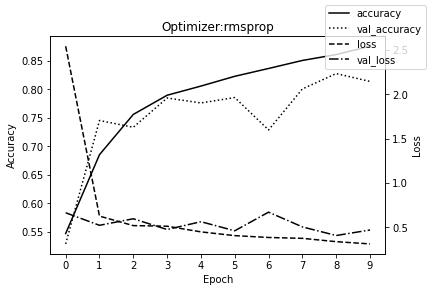

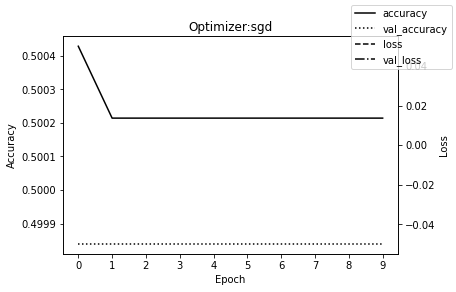

In [9]:
# train a model on each optimizer
for optim in optimizers:

    # Create the convolutional base
    model = tf.keras.models.Sequential(name=optim)
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(config.IMG_SIZE, config.IMG_SIZE, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

    # Add Dense layers on top
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(raw_data.get_labels_count()))

    # model.summary()

    # compile the model
    model.compile(optimizer=optim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    # train the model
    history = model.fit(training_images, training_labels, epochs=config.TRAINING_EPOCHS,
              validation_data=(test_images, test_labels))

    # Plot learning curve
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    ax1.plot(history.history["accuracy"], label = "accuracy", color = "k", linestyle = "solid")
    ax1.plot(history.history["val_accuracy"], label = "val_accuracy", color = "k", linestyle = "dotted")
    ax2.plot(history.history["loss"], label = "loss", color = "k", linestyle = "dashed")
    ax2.plot(history.history["val_loss"], label = "val_loss", color = "k", linestyle = "dashdot")
    ax1.set_xlabel("Epoch")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Loss")
    fig.legend()
    ax1.set_title("Optimizer:"+optim)

    # evaluate model
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

    # export the trained model
    export_trained_model(model, config.TRAINING_EPOCHS, test_loss, test_acc, history, fig, raw_data, config.MODEL_PATH)